///---
layout: post
title: "Lights Out 퍼즐 풀기"
comments: true
share: true
date: 2019-04-21 14:13:00
description: 주어진 초기 상태에서, 모든 버튼의 불을 끄는 버튼 순서를 찾아본다.
tags: python math
sitemap :
    changefreq : daily
    priority : 1.0
///---

# Lights Out 퍼즐 풀기

## Lights Out 퍼즐이란
아래 그림과 같이 일부만 켜져 있는 전구 판이 있을 때, 일정한 규칙에 따라 전구 판을 모두 끄는 퍼즐이다.  
퍼즐의 규칙은 간단하다. 한 버튼을 누르면 그 버튼과 버튼을 둘러싼 4개의 버튼 상태가 반대로 바뀐다.

In [1]:
# 설명 그림 Plot 용 코드
# Third party imports
from jupyterthemes import jtplot
from matplotlib.pyplot import subplots
from numpy import flipud, ndarray, vectorize
from numpy.core.numeric import array
from matplotlib.colors import ListedColormap

jtplot.style('monokai', fscale=1.3)

def draw_light_out_rule(light_before, light_after, push_pos):
    # cmap = 'CMRmap'
    cmap = ListedColormap(['k', 'g'])
    fig, ax = subplots(1, 3,
                       figsize=(10, 4),
                       gridspec_kw = {'width_ratios':[5, 1, 5]})

    ax[0].pcolor(flipud(light_before), cmap=cmap)
    ax[2].pcolor(flipud(light_after), cmap=cmap)

    ax[1].axis('off')
    ax[1].text(0.20, 0.4, f'Push\n{push_pos}\nbutton',
               color='w',
               ha="center",
               size=0.25 * fig.dpi,
               transform=ax[1].transAxes,
               bbox=dict(boxstyle='rarrow', fc="grey", ec="k"))
    
    ax[0].grid(True, color='grey', linewidth=3)
    ax[2].grid(True, color='grey', linewidth=3)
    
    ax[0].tick_params(labelleft=False,labelbottom= False)
    ax[2].tick_params(labelleft=False,labelbottom= False)


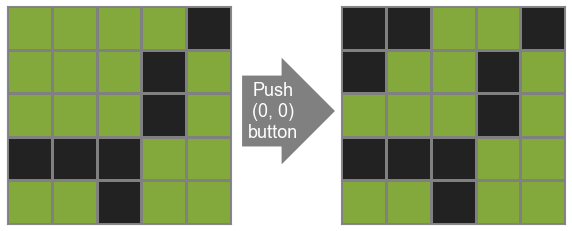

In [2]:
lights_before = array([[1, 1, 1, 1, 0],
                       [1, 1, 1, 0, 1],
                       [1, 1, 1, 0, 1],
                       [0, 0, 0, 1, 1],
                       [1, 1, 0, 1, 1]])

lights_after = array([[0, 0, 1, 1, 0],
                      [0, 1, 1, 0, 1],
                      [1, 1, 1, 0, 1],
                      [0, 0, 0, 1, 1],
                      [1, 1, 0, 1, 1]])

draw_light_out_rule(lights_before, lights_after, '(0, 0)')

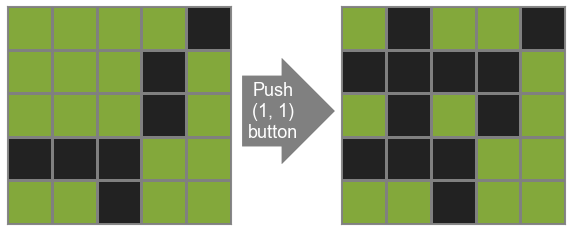

In [3]:
lights_before = array([[1, 1, 1, 1, 0],
                       [1, 1, 1, 0, 1],
                       [1, 1, 1, 0, 1],
                       [0, 0, 0, 1, 1],
                       [1, 1, 0, 1, 1]])

lights_after = array([[1, 0, 1, 1, 0],
                      [0, 0, 0, 0, 1],
                      [1, 0, 1, 0, 1],
                      [0, 0, 0, 1, 1],
                      [1, 1, 0, 1, 1]])

draw_light_out_rule(lights_before, lights_after, '(1, 1)')

## 수학적 접근

퍼즐을 대해 아래와 같은 질문을 할 수 있다.

- 풀 수 있는 퍼즐인가?
- 풀 수 있는 방법은 한가지 인가?
- 풀 수 있는 방법이 여러가지 일 경우 최소한의 노력으로 풀 수 있는 방법은 무엇인가?

위의 질문에 답을 하려면 수학적 접근이 필요하다.   

우선 퍼즐 문제를 수학 문제로 변환하기 위해서 버튼의 상태변화를 사칙연산으로 정의하고 퍼즐의 상태 변화를 행렬로 정의한다.

퍼즐의 상태 변화가 행렬로 정의 되면 Lights out 퍼즐은 간단한 선형대수학 문제로 바뀌게 되어 질문의 답을 쉽게 얻을 수 있다.

### Galois Field 2
GF(2)는 갈루아 필드(Galois Filed 2)를 간략하게 표현한 것이다.
갈루아 필드의 +, x는 아래와 같이 정의 된다.

In [4]:
from IPython.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table>' + 
        ''.join(['<td>' + table.to_html(index=False) + '</td>' for table in table_list]) +
        '</table>'
    )

In [5]:
from numpy import zeros
from pandas import DataFrame
data_mul = zeros((2,), dtype=[('x', 'i4'), ('0', 'i4'), ('1', 'i4')])
data_mul[:] = [(0, 0, 0), (1, 0, 1)]
df_mul = DataFrame(data_mul)

data_add = zeros((2,), dtype=[('+', 'i4'), ('0', 'i4'), ('1', 'i4')])
data_add[:] = [(0, 0, 1), (1, 1, 1)]
df_add = DataFrame(data_add)
multi_table([df_mul, df_add])

x,0,1
0,0,0
1,0,1
+,0,1
0,0,1
1,1,1


갈루아 필드의 특성은 다음과 같다.

- 덧셈은 modulo 2 이며, 이것은 배타적 논리합과 같다.
- 뺄셈은 덧셈과 동일하다. 1의 음수는 1이고, 0의 음수는 0이다.
- 곱셈은 일반적인 0, 1의 곱셈과 같다.

### Lights Out 퍼즐을 갈루아 필드로 표현

Lights Out 의 불이 켜진 상태를 1, 꺼진 상태를 0으로 놓는다. 그리고 버튼이 눌려서 상태가 변하는 것을 갈루아 필드의 +1로 생각해 보자.
  
```
켜진 상태(1) + 1 = 꺼진 상태(0)
꺼진 상태(0) + 1 = 켜진 상태(1)
```
위의 수식은 버튼이 눌렸을 때의 변화를 GF(2)의 덧셈으로 표현 가능함을 보여준다.

Light Out 문제는 GF(2)에 포함된 벡터의 덧셈 문제로 변환 될 수 있다.
문제를 간단하게 하기 위해 버튼을 2x2로 제한하면 상태 천이 벡터($v_i$)는 아래와 같이 정의 된다.

<table><td><table border="1" class="dataframe">
  <caption>v<sub>1</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>1</th>
      <th>1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>0</td>
    </tr>
  </tbody>
</table></td><td><table border="1" class="dataframe">
 <caption>v<sub>2</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>1</th>
      <th>0</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table></td><td><table border="1" class="dataframe">
 <caption>v<sub>3</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>1</th>
      <th>1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>1</td>
    </tr>
  </tbody>
</table></td><td><table border="1" class="dataframe">
 <caption>v<sub>4</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>0</th>
      <th>1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table></td></table>



<br>  
초기 상태를 $s$로 놓고 $s$를 0으로 만드는 버튼은 다음과 같이 표현 할 수 있다.

$$s + v_i + v_j + v_k \cdots = 0,\quad \quad \quad i\neq j\neq k\quad(v_1 + v_1 = 0\text{이므로})$$

즉 Lights Out 문제는 GF(2)에서 $s$가 $v_i$의 벡터의 합으로 표현 할수 있는가의 문제가 된다.

### 해법을 찾는 방안

상태 천이 벡터($v_i$)로 이루어진 상태 천이 행렬($M$)을 정의한다.

$$M=\left[ \begin{matrix} { v }_{ 1 } & { v }_{ 2 } & \cdots  & { v }_{ n-1 } & { v }_{ n } \end{matrix} \right]$$

Lights Out 문제는 GF2에서 아래의 수식의 $x$를 찾는 방정식 문제로 정리된다.

$$Mx=s$$

벡터들이 실수에서 정의 되어 있다면 이미 구현된 라이브러리들을 이용하여 ${M}^{-1}$를 쉽게 구할 수 있지만 GF2의 경우 ${M}^{-1}$를 직접 계산하여야 한다. GF2의 ${M}^{-1}$는 Gauss Elimination을 이용하여 구할 수 있다.

$M$은 퍼즐의 크기에 따라서 Full Rank일 경우도 있고 그렇지 않은 경우도 있다.

만약 Full Rank일 경우에는 퍼즐의 모든 초기 상태에 대해서 유일한 해답을 가진다.

만약 Full Rank가 아닐 경우에는 퍼즐의 초기 상태에 따라서 풀이법이 없거나 여러가지 풀이법을 가질 수 있다. 초기 상태가 M의 Null Space와 내적하여 값을 가질 경우에는 퍼즐의 답을 찾을 수 없다. 퍼즐이 Null space를 포함하지 않을 경우 해법은 $x$와 null space의 조합으로 여러개가 존재한다.

## Python 코드

### Galois Field [2]
Python에서 Galois Field를 표현하기 위해서 Class를 선언한다.

In [6]:
# Show in Markdown
class GF2(object):
    """Galois field GF(2)."""

    def __init__(self, a=0):
        self.value = int(a) % 2

    def __add__(self, rhs):
        """."""
        return GF2(self.value + GF2(rhs).value)

    def __mul__(self, rhs):
        """."""
        return GF2(self.value * GF2(rhs).value)

    def __sub__(self, rhs):
        """."""
        return GF2(self.value - GF2(rhs).value)

    def __truediv__(self, rhs):
        """."""
        return GF2(self.value / GF2(rhs).value)

    def __repr__(self):
        """."""
        return str(self.value)

    def __eq__(self, rhs):
        """."""
        if isinstance(rhs, GF2):
            return self.value == rhs.value
        return self.value == rhs

    def __le__(self, rhs):
        """."""
        if isinstance(rhs, GF2):
            return self.value <= rhs.value
        return self.value <= rhs

    def __lt__(self, rhs):
        """."""
        if isinstance(rhs, GF2):
            return self.value < rhs.value
        return self.value < rhs

    def __int__(self):
        """."""
        return self.value

    def __long__(self):
        """."""
        return self.value
    
GF2array = vectorize(GF2)

### 상태 천이 행렬 생성
상태 천이 벡터($v_i$)가 하나의 열로 구성된 상태 천이 행렬을 생성한다.

In [7]:
# Show in Markdown
def draw_state_trasition(state, ax, grid_width=3):
    """Plot State-Transition Matrix"""
    from numpy import arange
    cmap = ListedColormap(['k', 'g'])
    ax.pcolor(flipud(state), cmap=cmap)
    ax.set_xticks(arange(state.shape[1]))
    ax.set_yticks(arange(state.shape[0]))
    ax.grid(True, color='grey', linewidth=grid_width)
    ax.tick_params(labelleft=False,labelbottom= False)

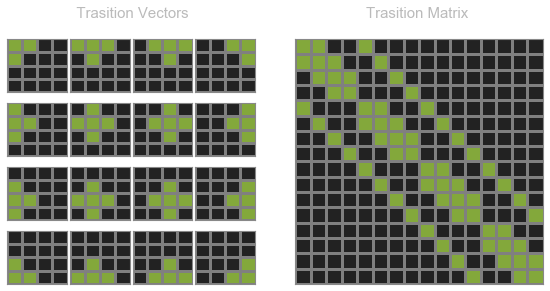

In [8]:
# Show in Markdown
from numpy import zeros
from matplotlib.pyplot import figure, subplot
from matplotlib.gridspec import GridSpec

def state_transition_matrix_lightsout(n, grid_spec):
    """Calculate state trasition matrix of light out."""
    matrix = zeros((n * n, n * n))

    for idx_row in range(1, n + 1):
        for idx_col in range(1, n + 1):
            vector = zeros((n + 2, n + 2))
            vector[idx_row - 1, idx_col + 0] = 1
            vector[idx_row + 1, idx_col + 0] = 1
            vector[idx_row + 0, idx_col + 0] = 1
            vector[idx_row + 0, idx_col + 1] = 1
            vector[idx_row + 0, idx_col - 1] = 1
            vector = vector[1:n + 1, 1:n + 1]

            ax = subplot(grid_spec[idx_row - 1, idx_col - 1])
            draw_state_trasition(vector, ax)

            matrix[(idx_row - 1) * n + (idx_col - 1) , :] = vector.ravel()

    return matrix


n_lightsout = 4

fig = figure(figsize=(8, 4.5))

fig.suptitle("   Trasition Vectors                                           Trasition Matrix",
             fontsize=15)
gs1 = GridSpec(n_lightsout, n_lightsout, figure=fig)
gs1.update(left=0.05, right=0.48, wspace=0.05)

gs2 = GridSpec(n_lightsout, n_lightsout, figure=fig)
gs2.update(left=0.55, right=0.98)

state_mat = state_transition_matrix_lightsout(n_lightsout, gs1)

ax = subplot(gs2[:, :])
draw_state_trasition(state_mat, ax)

### 역행렬 및 Null Space 계산
Gauss Elimination을 이용하여 역행렬과 Null Space를 계산한다.

In [9]:
# Show in Markdown
import numpy as np
from numpy import hstack, eye, where, vstack, int32

def inv_by_gauss_elimination(mat):
    """Caculate inverse matrix by gauss elimination.

    Parameters
    ----------
    mat : ndarray
        matrix.

    Returns
    -------
    mat_inv : ndarray
        inverse matrix.
    mat_null : ndarray
        null space matrix.

    """
    n_row, n_col = mat.shape

    if n_row != n_col:
        raise ValueError("n_row and n_col are diffrents.")

    data = GF2array(hstack([mat, eye(n_row)]))

    n_null_dim = 0
    mat_null = array([])

    # Row echelon form
    for idx_row_src in range(n_row - 1):
        idx_pivot_candidate = where(data[idx_row_src:, idx_row_src] == 1)[0]

        if len(idx_pivot_candidate) > 0:
            idx_pivot = idx_pivot_candidate[0] + idx_row_src
        else:
            n_null_dim += 1
            continue

        if idx_pivot != idx_row_src:
            tmp = data[idx_row_src, :].copy()
            data[idx_row_src, :] = data[idx_pivot, :]
            data[idx_pivot, :] = tmp

        for idx_row_dst in range(idx_row_src + 1, n_row):
            data[idx_row_dst, :] += (data[idx_row_src, :]
                                     * data[idx_row_dst, idx_row_src])

    if np.sum(data[-1, :n_col]) == 0:
        n_null_dim += 1

    # inverse matrix
    for idx_row_src in range(n_row - 1, 0, -1):
        for idx_row_dst in range(idx_row_src - 1, -1, -1):
            data[idx_row_dst, :] += (data[idx_row_src, :]
                                     * data[idx_row_dst, idx_row_src])

    # Find Null space
    if n_null_dim > 0:
        mat_diag = data[:, :n_col]
        mat_null = vstack(
            [mat_diag[:n_row - n_null_dim, -n_null_dim:],
             GF2array(eye(n_null_dim))])

    mat_inv = data[-n_row:, -n_col:]

    return mat_inv, mat_null

### 풀 수 있는 문제인지 확인
켜져 있는 Light와 Null Space를 내적하여 0이면 풀수 있는 문제

In [10]:
# Show in Markdown
def check_solvable(lights_mat, mat_null):
    """Check if the problem is solved.

    Parameters
    ----------
    lights_mat : ndarray
        matrix of lightout problem.
    mat_null : ndarray
        null space matrix.

    Returns
    -------
    is_solvable: bool
        return True if lights_mat is solvable.

    """
    is_solvable = True

    if len(mat_null) > 0:
        ret = np.sum((int32(lights_mat.ravel()) @ int32(mat_null)) % 2)
        if ret != 0:
            is_solvable = False

    return is_solvable

### 결과 확인

#### 역행렬 계산

In [11]:
# Show in Markdown
state_mat_inv, state_mat_null = inv_by_gauss_elimination(state_mat)

#### Null Space가 잘 계산되어 있는지 확인

In [12]:
# Show in Markdown
if len(state_mat_null) > 0:
    print(f"No. vectors of null space is {state_mat_null.shape[1]}.")
    ret = (int32(state_mat) @ int32(state_mat_null)) % 2
    has_value = np.any(ret)
    if has_value:
        print("====> Null Space is wrong. <====")
    else:
        print("Null Space is correct.")
else:
    print("No. vectors of null space is 0.")

No. vectors of null space is 4.
Null Space is correct.


#### 문제 풀이

In [13]:
# Show in Markdown
lights_mat = array([[1, 0, 0, 1],
                    [1, 1, 1, 1],
                    [1, 0, 0, 1],
                    [0, 0, 0, 0]])

is_solvable = check_solvable(lights_mat, state_mat_null)
print(f'Solvable {is_solvable}')

solution = (int32(state_mat_inv) @ int32(lights_mat.ravel())) % 2
solution = solution.reshape(n_lightsout, n_lightsout)

Solvable True


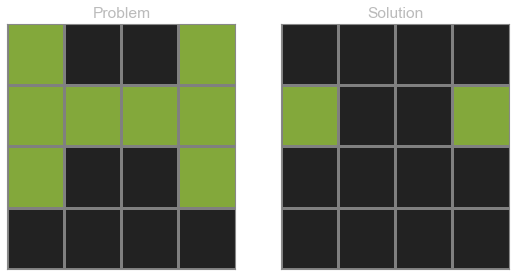

In [14]:
fig, ax = subplots(1, 2, figsize=(9, 4.5))
draw_state_trasition(lights_mat, ax[0])
draw_state_trasition(solution, ax[1])

ax[0].set_title("Problem")
_ = ax[1].set_title("Solution")

## 게임

위에서 설명된 수식을 이용하여 간단한 게임을 만들 수 있다.[3]

<figure>
    <img src='../assets/images/LightsOut/DemoLightsOut.gif' alt='Game Demo' width="240" />
    <figcaption class="figure-caption">Game Demo</figcaption>
</figure>

## 참고자료
[1] 필립 클라인. (2019). 3. 벡터. Coding The Matrix (90)  
[2] https://github.com/pmneila/Lights-Out
[3] https://github.com/ok97465/GameLightsOut